# Thesis 

In [1]:
import import_ipynb
from Auxillary_functions import *
import ECoG

importing Jupyter notebook from Auxillary_functions.ipynb


### Данные 

Будем рассматривать в качестве выборок несоклько вариантов разбиения данных.
Первый случай: данные об одной обезьяне, снятые в разные дни. Ведь в идеале хочется достичь результата, при котором модель, построенная один раз, работала ,бы для последующих экспериментов.
Второй случай: стандартное разбиение одной выборки на train/test. 

Рассматриваем subdural ECoG for monkey K from 27.05.2009

In [2]:
centers = [(4,1), (6, 1), (8,1),\
           (3, 2), (5, 2), (7,2),\
           (2, 3), (4, 3), (6, 3), (8,3),\
           (1, 4), (3, 4), (5, 4), (7, 4),\
           (2, 5), (4, 5), (6, 5), \
           (1, 6), (3, 6), (5, 6), (7, 6),\
           (2, 7), (4, 7), (6, 7), (8, 7),\
           (1, 8), (3, 8), (5, 8), (7, 8),\
           (2, 9), (4, 9), (6, 9), (8, 9),\
           (1, 10), (3, 10), (5, 10), (7, 10),\
           (2, 11), (4, 11), (6, 11), (8, 11),\
           (1, 12), (3, 12), (5, 12), (7, 12),\
           (2, 13), (4, 13), (6, 13), (8, 13),\
           (1, 14), (3, 14), (5, 14), (7, 14),\
           (2, 15), (4, 15), (6, 15), (8, 15),\
           (1, 16), (3, 16), (5, 16), (7, 16),\
           (2, 17), (4, 17), (6, 17)]

### Raw ECoG 

In [3]:
x,y = ECoG.read_ECoG_from_csv("ECoG.csv","Motion.csv")
data = ECoG.ECoG(x,y,downsample = True)

In [4]:
plt.figure(figsize=(14,6))
plt.plot(x[:,0], x[:,64])
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #64', **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Напряжение, мВ', **axis_font)
plt.grid(True)
#plt.show()
plt.close()

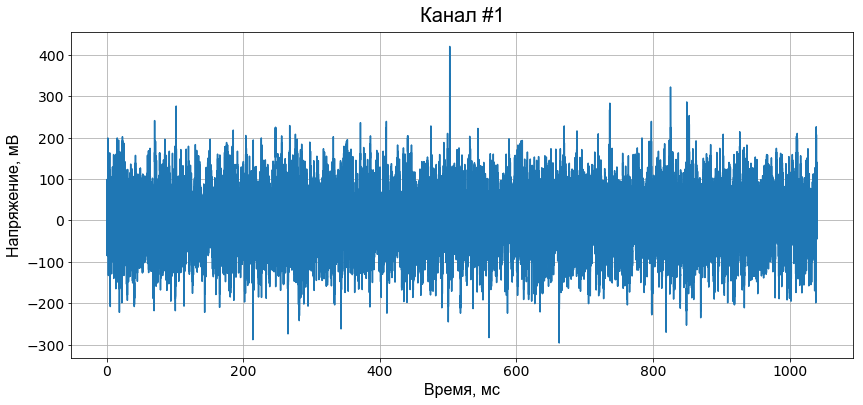

In [5]:
plot_ecog(x[:,0], x[:,1:])

### Гипотезы нормального/гамма распределения 

##### Подготовка данных и параметров 

In [6]:
signal_data = np.array(x)
motion_data = np.array(y)

In [7]:
#simple sync
time, signal_idx, motion_idx = np.intersect1d(signal_data[:,0], motion_data[:,0],assume_unique=True, return_indices=True)
ecog_signal = signal_data[signal_idx]
motion = motion_data[motion_idx]

In [8]:
new_signal = np.array(pd.DataFrame(signal_data).ewm(span = 7).mean())

In [35]:
#ewma sync
ecog_signal = []
time, signal_idx, motion_idx = np.intersect1d(signal_data[:,0], motion_data[:,0],assume_unique=True, return_indices=True)
ecog_signal = new_signal[signal_idx]
motion = motion_data[motion_idx]

In [10]:
N = len(time)

In [11]:
%%time
m = get_mean(ecog_signal[:N, 1:], time[:N])
d = get_disp(m, ecog_signal[:N, 1:], time[:N])

Wall time: 25.8 s


In [12]:
%%time
#Calcuate bivariate normal distribution for each moment of time

mv = []
for i in range(len(m)):
    mv.append(multivariate_normal([m[i, 0], m[i, 1]], [[d[i,0], 0], [0, d[i, 1]]]))


Wall time: 18.5 s


In [13]:
%%time
intens = get_intens(m, d, mv, ecog_signal[:N, 1:], time[:N])

Wall time: 3.41 s


In [14]:
m = get_mean(signal_data[:N, 1:], signal_data[:N,0])
d = get_disp(m, signal_data[:N, 1:], signal_data[:N, 0])
mv = []
for i in range(len(m)):
    mv.append(multivariate_normal([m[i, 0], m[i, 1]], [[d[i,0], 0], [0, d[i, 1]]]))
intens = get_intens(m, d, mv, signal_data[:N, 1:], signal_data[:N,0])

##### Нормальное распределение

###### Не нормализованное, с поправкой на интенсивность

In [63]:
intens_multiplier = True
mae = []
mse = []
r2 = []
for channel in range(1,64):
    point = centers[channel]
    rv = []

    for j in range(len(mv)):
            p = mv[j].pdf(point)
            if intens_multiplier == True:
                rv.append(p*intens[j])
            else:
                rv.append(p)
                
    mae.append(mean_absolute_error(rv, ecog_signal[:, channel]))
    mse.append(mean_squared_error(rv, ecog_signal[:, channel]))
    r2.append(r2_score(rv, ecog_signal[:, channel]))

In [64]:
print ('mae: ', np.array(mae).mean(), '\n mse:', np.array(mse).mean(), '\n r2-score: ', np.array(r2).mean())

mae:  88.74589343813625 
 mse: 21216.735895340607 
 r2-score:  -0.05489729359383058


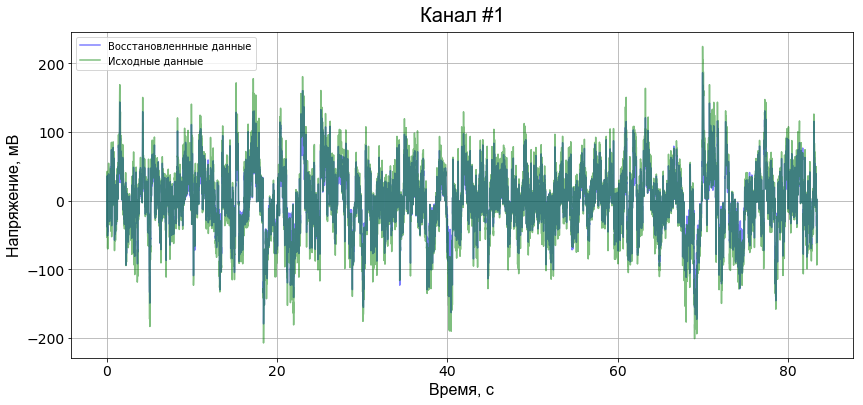

In [65]:
#N = len(time)
N = 10000
for channel in range(1, 2):
    point = centers[channel]
    rv = []

    for j in range(len(mv[:N])):
            p = mv[j].pdf(point)
            if intens_multiplier == True:
                rv.append(p*intens[j])
            else:
                rv.append(p)
                
    plt.figure(figsize=(14,6))
    plt.plot(time[:N], rv, color='blue', alpha = 0.5, label = 'Восстановленнные данные')
    plt.plot(time[:N], ecog_signal[:N, channel], color='green', alpha = 0.5, label = 'Исходные данные')
    plt.xticks( fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    plt.title('Канал #%i' %channel, **title_font)
    plt.xlabel('Время, с', **axis_font)
    plt.ylabel('Напряжение, мВ', **axis_font)
    plt.legend()
    plt.grid(True)
    plt.show()
    

###### Распределение висхарта

###### Ненормализованное, с поправкой на интенсивность

In [68]:
intens_multiplier = True
mae = []
mse = []
r2 = []
for channel in range(1,64):
    point = centers[channel]
    g_d = []

    for j in range(len(m)):
        p = wishart.pdf(point, 2, [[m[j, 0], 0], [0, m[j, 1]]])
        if intens_multiplier == True:
            g_d.append(p*intens[j])
        else:
            g_d.append(p)    
    mae.append(mean_absolute_error(g_d, ecog_signal[:, channel]))
    mse.append(mean_squared_error(g_d, ecog_signal[:, channel]))
    r2.append(r2_score(g_d, ecog_signal[:, channel]))

In [69]:
print ('mae: ', np.array(mae).mean(), '\n mse:', np.array(mse).mean(), '\n r2-score: ', np.array(r2).mean())

mae:  34.566348644248706 
 mse: 2103.388494315041 
 r2-score:  -1024.666103720442


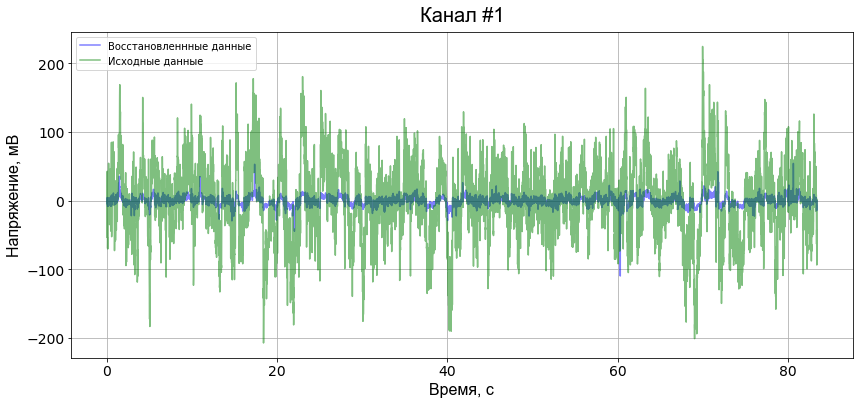

In [70]:
#N = len(time)
N = 10000
for channel in range(1, 2):
    point = centers[channel]
    g_d = []
    for j in range(len(m[:N])):
        p = wishart.pdf(point, 2, [[m[j, 0], 0], [0, m[j, 1]]])
        if intens_multiplier == True:
            g_d.append(p*intens[j])
        else:
            g_d.append(p)

    plt.figure(figsize=(14,6))
    plt.plot(time[:N], g_d, color='blue', alpha = 0.5, label = 'Восстановленнные данные')
    plt.plot(time[:N], ecog_signal[:N, channel], color='green', alpha = 0.5, label = 'Исходные данные')
    plt.xticks( fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    plt.title('Канал #%i' %channel, **title_font)
    plt.xlabel('Время, с', **axis_font)
    plt.ylabel('Напряжение, мВ', **axis_font)
    plt.legend()
    plt.grid(True)
    plt.show()

##### Построение регресси для предсказани движения по параметрам вышеуказанных локальных моделей

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [19]:
X = np.c_[m, d, intens]

In [20]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [43]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, motion[:, 1:], test_size=0.35, shuffle = False)
#model = LinearRegression(n_jobs = -1)


model = RandomForestRegressor(n_estimators=500,  n_jobs=-1, random_state=42)
model.fit(Xr_train,yr_train)
Y_pred = model.predict(Xr_test)


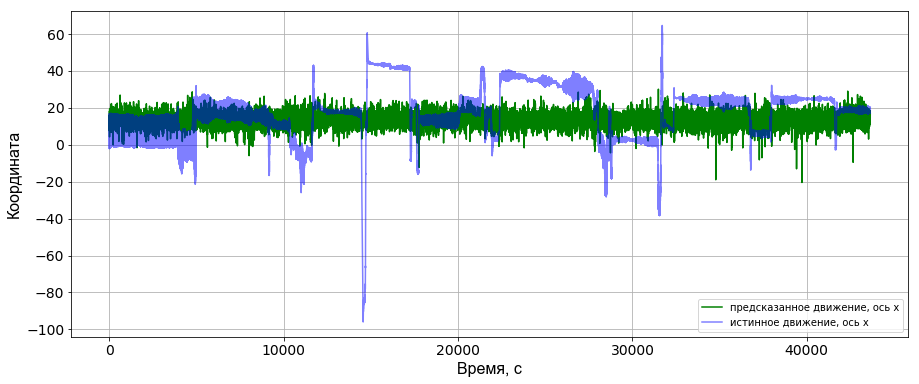

In [44]:
plt.figure(figsize = (15,6))
plt.plot(Y_pred[:, 1], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(np.array(yr_test)[:, 1], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [ ]:
print(' mae: ', mean_absolute_error(yr_test[:,1:], Y_pred),'\n mse: ',mean_squared_error(yr_test[:,1:], Y_pred),'\n r2-score: ',\
      r2_score(yr_test[:,1:],Y_pred))

### Линейная модель экога по параметрам среднего, дисперсии и интенсивности

In [238]:
n_sample = int(len(signal_data)/3)

In [239]:
channel = 14
y_train = signal_data[:n_sample, channel]

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, ecog_signal[:, 1:], test_size = 0.33, shuffle= False)

In [241]:
reg = LinearRegression().fit(X_train, y_train)

In [242]:
y_pred = reg.predict(X_test)
#reg.coef_

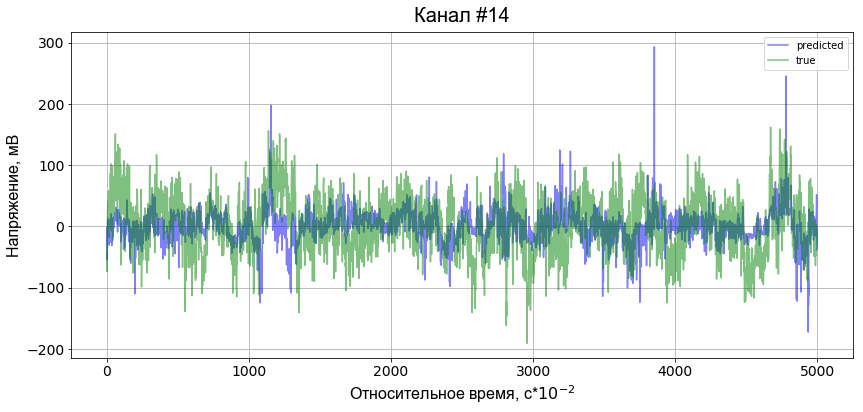

In [243]:
#N = len(time)
N = 5000
plt.figure(figsize = (14, 6))
plt.plot(range(len(y_pred[:N, 1])),y_pred[:N,1], alpha = 0.5, color = 'blue', label = 'predicted')
plt.plot(range(len(y_pred[:N, 1])),y_test[:N,1], alpha = 0.5, color = 'green', label = 'true')
plt.legend()
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Относительное время, с*$10^{-2}$', **axis_font)
plt.ylabel('Напряжение, мВ', **axis_font)
plt.grid(True)
plt.show()

In [244]:
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      r2_score(y_test,y_pred))

 mae:  34.66748979942134 
 mse:  2117.987429457212 
 r2-score:  0.10762342687096271


In [27]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor( criterion='mse', max_depth=20, min_samples_split=2, min_samples_leaf=1,\
                                 min_weight_fraction_leaf=0.0, max_features='auto', \
                                 max_leaf_nodes=None,bootstrap=True, n_jobs=-1, random_state=42, warm_start=False)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [246]:
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

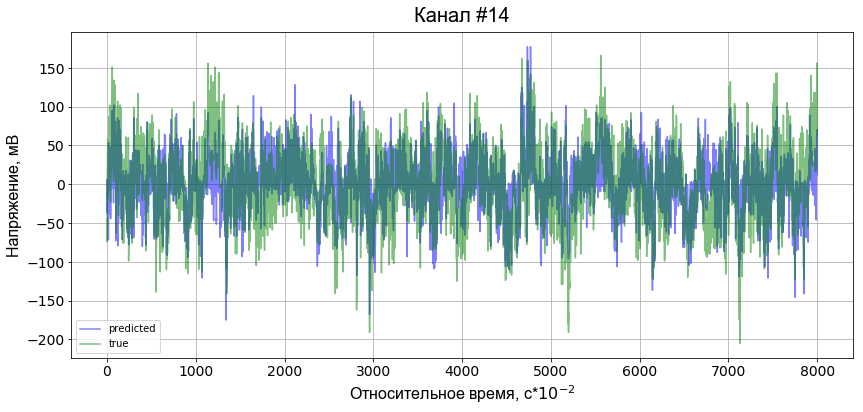

In [247]:
N = 8000
plt.figure(figsize = (14, 6))
plt.plot(range(len(y_pred[:N])),y_pred[:N,1], alpha = 0.5, color = 'blue', label = 'predicted')
plt.plot(range(len(y_pred[:N])),y_test[:N,1], alpha = 0.5, color = 'green', label = 'true')
plt.legend()
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Относительное время, с*$10^{-2}$', **axis_font)
plt.ylabel('Напряжение, мВ', **axis_font)
plt.grid(True)
plt.show()

In [248]:
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      r2_score(y_test,y_pred))

 mae:  31.28821087443399 
 mse:  1814.6537884174336 
 r2-score:  0.25603397029731795


####  Эксперимент с расширением признакового пространства парой статистик


In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
m_s = []
d_s = []
min_s = []
max_s = []
for i in range(len(m)):
    m_s.append(ecog_signal[i, 1:].mean())
    d_s.append(ecog_signal[i, 1:].std())
    min_s.append(min(ecog_signal[i, 1:]))   
    max_s.append(max(ecog_signal[i, 1:]))   

In [12]:
X = np.c_[m, d, intens, m_s, d_s, min_s, max_s]

In [13]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

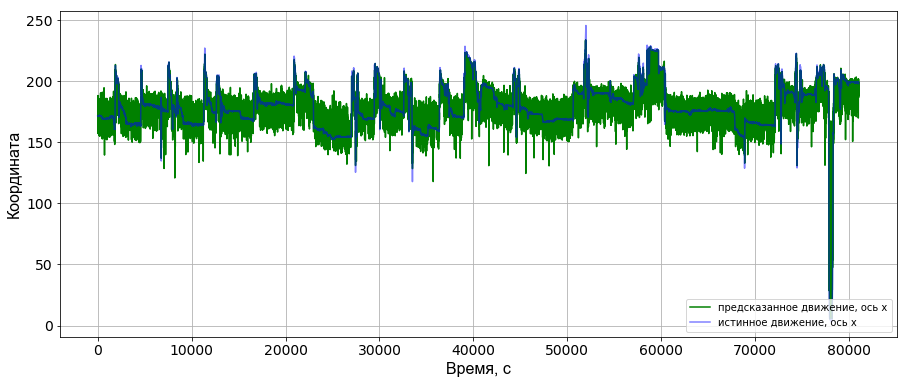

In [41]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, motion[:, 1:], test_size=0.35, shuffle = False)
'''model = LinearRegression(n_jobs = -1)
model.fit(Xr_train,yr_train)
y_pred = model.predict(Xr_train)
'''
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor( criterion='mse', max_depth=50, min_samples_split=2, min_samples_leaf=1,\
                                 min_weight_fraction_leaf=0.0, max_features='auto', \
                                 max_leaf_nodes=None,bootstrap=True, n_jobs=-1, random_state=42, warm_start=False)

model_rf.fit(Xr_train, yr_train)
y_pred = model_rf.predict(Xr_train)
plt.figure(figsize = (15,6))
plt.plot(y_pred[:, 0], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(yr_train[:, 0], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [38]:
from sklearn.metrics import r2_score
r2_score(yr_test[:,1],y_pred[:, 1])

-0.1716935895189995

In [29]:
from  sklearn.model_selection import GridSearchCV
sth = GridSearchCV(model_rf, param_grid = [
    {'max_depth': np.arange(1, 101, 10)}], scoring='r2', n_jobs=-1, cv = 5, return_train_score=True)

In [30]:
sth.fit(Xr_train,yr_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [31]:
sth.best_params_

{'max_depth': 1}

In [36]:
sth.cv_results_

{'mean_fit_time': array([ 0.23725801,  4.68985715,  8.98277259, 12.24624596, 12.82569671,
        14.70127964, 13.22223601, 14.04922471, 15.86776004, 11.20805545]),
 'std_fit_time': array([0.00504456, 2.27148523, 1.08252109, 1.44678842, 0.96116353,
        0.74128426, 1.39000957, 0.7364561 , 1.06456783, 2.88878265]),
 'mean_score_time': array([0.10619574, 1.81853566, 2.19792161, 3.11107936, 3.22258086,
        2.40995407, 3.01373982, 2.16999626, 2.50629673, 1.14595428]),
 'std_score_time': array([4.71937359e-04, 1.41614509e+00, 7.10144158e-01, 8.83394093e-01,
        9.00377281e-01, 9.80408457e-02, 1.66715997e+00, 9.62068597e-01,
        6.69016326e-01, 1.26390514e+00]),
 'param_max_depth': masked_array(data=[1, 11, 21, 31, 41, 51, 61, 71, 81, 91],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1},
  {'max_depth': 11},
  {'max_depth': 21},
  {'ma

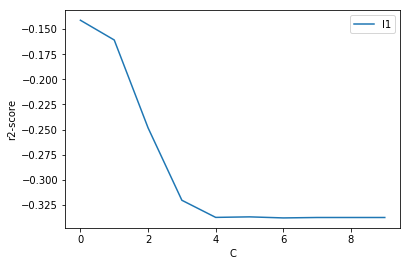

In [35]:
tmp = sth.cv_results_['mean_test_score']

plt.plot(tmp,label="l1")
plt.legend()
plt.xlabel("C")
plt.ylabel("r2-score")
plt.show()

In [43]:
time[:15]

array([0.   , 0.008, 0.017, 0.025, 0.033, 0.042, 0.05 , 0.058, 0.067,
       0.075, 0.083, 0.092, 0.1  , 0.108, 0.117])

In [45]:
x[:15, 0]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014])

In [15]:
from sklearn.linear_model import Ridge

In [72]:
clf = Ridge(alpha=0.0001, normalize=True,  solver="auto", random_state=42)

In [74]:
clf.coef_

array([ 1.36216703e+00, -4.48658684e-01, -2.48534936e+00, -2.23523488e-02,
        8.42683748e-06])

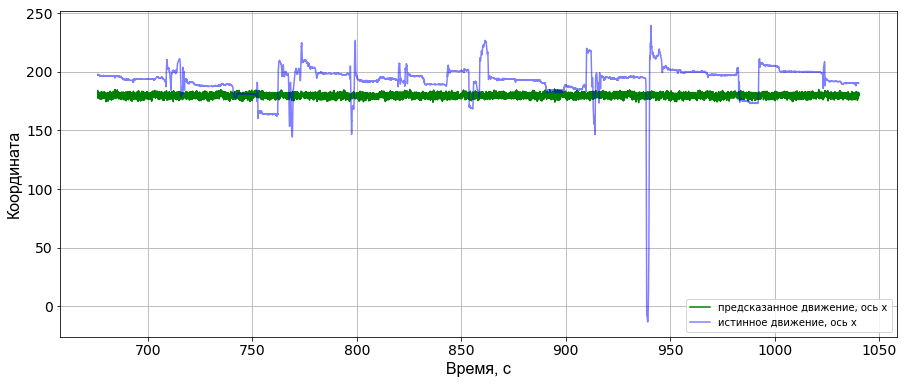

In [73]:
X = np.c_[m, d, intens]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, motion[:, 1:], test_size=0.35, shuffle = False)
clf.fit(Xr_train,yr_train[:, 0])
Y_pred = clf.predict(Xr_test)

plt.figure(figsize = (15,6))
plt.plot(time[-(len(Y_pred)):],Y_pred[:], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(time[-(len(Y_pred)):],yr_test[:, 0], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Канал #%i' %channel, **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [17]:
clf.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [52]:
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(ecog_signal, ecog_signal, time, test_size = 0.33, random_state = 42, shuffle = False)


In [40]:
a = []
b = []
c = []
intens = []
for i in range(len(ecog_signal)):
    step = ecog_signal[i, 1:]
    x = sum(step)/64 
    s = 1/63*(sum((step - x)**2))
    m3 = 1/64*(sum((step - x)**3))
    a.append(4*s**3/(m3**2))
    b.append(0.5*m3/s)
    c.append(x-2*s**2/m3)
    intens.append(np.max(step))

In [56]:
params = np.c_[a, b, c, intens]
X_train, X_test = train_test_split(params, test_size = 0.33, random_state = 42, shuffle = False)

In [57]:
from sklearn.linear_model import Lasso
lr = RandomForestRegressor
lr.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
Y_pred = lr.predict(X_test)

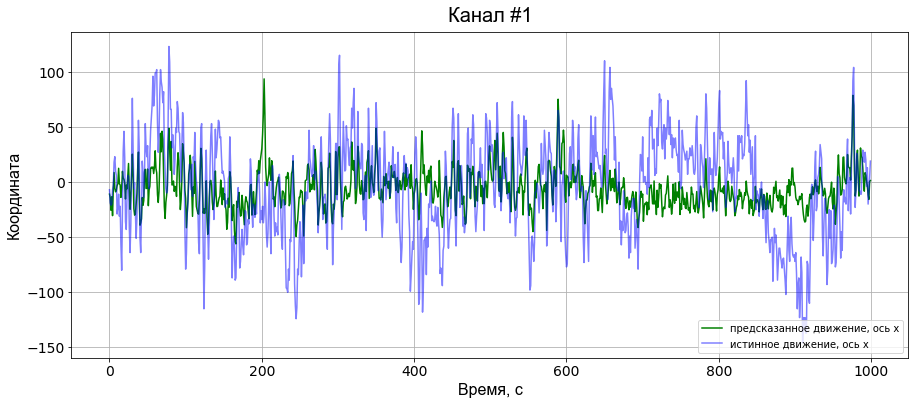

In [63]:
plt.figure(figsize = (15,6))
plt.plot(Y_pred[:1000, 1], color = 'green',label = 'предсказанное движение, ось х')
plt.plot(y_test[:1000, 1], color = 'blue', alpha = 0.5, label = 'истинное движение, ось х')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('Канал #1', **title_font)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

In [65]:
print(' mae: ', mean_absolute_error(y_test, Y_pred),'\n mse: ',mean_squared_error(y_test, Y_pred),'\n r2-score: ',\
      r2_score(y_test,Y_pred))

 mae:  39.26067238837091 
 mse:  6028.468958680046 
 r2-score:  -0.159563171104441
